In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import glob
from collections import namedtuple
import os
import contextily as ctx
from scipy.spatial import cKDTree
from shapely.geometry import Point, shape, LineString, MultiLineString, GeometryCollection, MultiPoint, Polygon, MultiPolygon  # creating points
import json
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map, thread_map
pd.set_option('min_rows', 30)
import sys
from importlib import reload
from util import *
import matplotlib.pyplot as plt
import multiprocessing
# from pandarallel import pandarallel # parallel operations for speed
# pandarallel.initialize(nb_workers=8, progress_bar=True)
# import swifter
tqdm.pandas()
plt.rcParams['figure.figsize'] = (16, 16)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
gpd.options.use_pygeos 

True

In [2]:
import time
start = time.time()
last = time.time()

In [3]:
max_workers = 30

## Setup

In [ ]:
# %%time
parcels = gpd.read_file('input/lds-nz-primary-parcels-FGDB.zip!nz-primary-parcels.gdb')

parcels = parcels[parcels.land_district.isin(['North Auckland', 'South Auckland'])].to_crs(4326)

parcels['geometry_polygon_4326'] = parcels.geometry
parcels['geometry_polygon_2193'] = parcels.geometry.to_crs(2193)

parcels['geometry_centroid_2193'] = parcels['geometry_polygon_2193'].centroid
parcels['representative_point_2193'] = parcels['geometry_polygon_2193'].representative_point()

parcels['geometry_centroid_4326'] = parcels['geometry_centroid_2193'].to_crs(4326)
parcels['representative_point_4326'] = parcels['representative_point_2193'].to_crs(4326)

parcels.sindex

In [6]:
# get the current columns, so that any columns added later can be selected and saved to disk
orginal_columns = parcels.columns

In [7]:
# this is the actual set of parcels that will have the information added
# it could be a copy of parcels, a sample of parcels, etc.
parcels_output = parcels.copy()
parcels_output.sindex

In [8]:
print('loading parcels complete')
print(time.time() - last, 'seconds')
last = time.time()
print()

loading parcels complete
95.08596920967102 seconds



## 1. LINZ parcel information
##### a. **LINZ_parcel_ID** Parcel identifier - “certificate of title”.


In [9]:
parcels_output['LINZ_parcel_ID'] = parcels_output.id

In [10]:
print('1a complete')
print(time.time() - last, 'seconds')
last = time.time()
print()

1a complete
0.023302078247070312 seconds



##### b. **LINZ_parcel_centroid_lon**
##### c. **LINZ_parcel_centroid_lat**

In [11]:
parcels_output['geometry'] = parcels_output.geometry_centroid_4326
parcels_output = parcels_output.set_crs(4326)
parcels_output['LINZ_parcel_centroid_lon'] = parcels_output.geometry.x
parcels_output['LINZ_parcel_centroid_lat'] = parcels_output.geometry.y

In [12]:
print('1bc complete')
print(time.time() - last, 'seconds')
last = time.time()
print()

1bc complete
0.6859390735626221 seconds



##### d. **LINZ_parcel_vertices_lon** vector of longitudes of the vertices of the matched LINZ parcels 
##### e. **LINZ_parcel_vertices_lat**

In [13]:
# %%time
parcels_output['geometry'] = parcels_output.geometry_polygon_4326
parcels_output = parcels_output.set_crs(4326)

def extract_verts(geometry):
    lat = np.nan
    lng = np.nan
    if geometry:
        coordinates = []
        for polygon in geometry:
            # the last point is the same as the first
            coordinates.extend(polygon.exterior.coords[:-1])
        lng = f"[{'; '.join([str(round(point[0], 6)) for point in coordinates])}]"
        lat = f"[{'; '.join([str(round(point[1], 6)) for point in coordinates])}]"
    return lng, lat



# lowering chunk size to 1 greatly lengthens time here.
# upping chunk size to 10000 doesn't have much impact
vertices = process_map(extract_verts, parcels_output.geometry, max_workers=max_workers, chunksize=100)
parcels_output["LINZ_parcel_vertices_lon"] = [v[0] for v in vertices]
parcels_output["LINZ_parcel_vertices_lat"] = [v[1] for v in vertices]

  0%|          | 0/537289 [00:00<?, ?it/s]

In [14]:
print('1de complete')
print(time.time() - last, 'seconds')
last = time.time()
print()

1de complete
78.06095385551453 seconds



##### f. **LINZ_parcel_roadvertices_lon** subvector of longitudes of parcel that sits adjacent to a road 
##### g. **LINZ_parcel_roadvertices_lat**

In [15]:
parcels_output['geometry'] = parcels_output.geometry_polygon_4326
parcels_output = parcels_output.set_crs(4326)
parcels['geometry'] = parcels.geometry_polygon_4326
parcels = parcels.set_crs(4326)

In [16]:
roads = parcels[parcels.parcel_intent == "Road"]
roads = roads.to_crs(parcels.crs)

In [17]:
# %%time
roads_dissolved = roads.dissolve()

In [20]:
def pointarray2matarrays(pointarray):
    """list of points to matlab compatible arrays of longs and lats
    
    i.e.
    [point1, point2,...] -> 'point1_x; point2_x; ...', 'point1_y; point2_y; ...'
    """
    lon = [point.xy[0][0] for point in pointarray]
    lat = [point.xy[1][0] for point in pointarray]
    lon = f"[{'; '.join([str(round(lon, 6)) for lon in list(lon)])}]"
    lat = f"[{'; '.join([str(round(lat, 6)) for lat in list(lat)])}]"
    return lon, lat


def get_points_in_roads(row, return_matarray=True):
    """return a list of points from the geometry that fall within roads_dissolved"""
    # assume multipolygon
    if row[1].parcel_intent == 'road':
        return None
    geom = row[1].geometry
    assert isinstance(geom, MultiPolygon), f"not implemented for geometry of type {type(geom)}"
    road_points = []
    # iterate over polygons
    for poly in geom:
        # split polygon into vertices
        # the last point is the same as the first
        coords = poly.exterior.coords[:-1]
        pointsx = [x for x, _ in coords]
        pointsy = [y for _, y in coords]
        # create gdf with one row per vertex
        points_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(pointsx, pointsy)).set_crs(4326)
        # sjoin with roads, to eliminate vertices that don't intersect a road
        road_points.extend(gpd.sjoin(points_gdf, roads_dissolved, op = 'intersects').geometry.values)
    # split into matlab compatible longs and lats like [(longs_list, lats_list), (longs_list, lats_list),...]
    if return_matarray:
        road_points = pointarray2matarrays(road_points)
    return road_points

In [21]:
# %%time
# this might hang for a few minutes before multiprocessing starts
road_intersections = process_map(get_points_in_roads, parcels_output.iterrows(), max_workers=max_workers, chunksize=100, total=len(parcels_output))

parcels_output['LINZ_parcel_roadvertices_lon'] = [r[0] for r in road_intersections]
parcels_output['LINZ_parcel_roadvertices_lat'] = [r[1] for r in road_intersections]

  0%|          | 0/537289 [00:00<?, ?it/s]

In [22]:
parcels_output[~parcels_output.LINZ_parcel_roadvertices_lat.isin([[]])]

,id,appellation,affected_surveys,parcel_intent,topology_type,statutory_actions,land_district,titles,survey_area,calc_area,geometry,geometry_polygon_4326,geometry_polygon_2193,geometry_centroid_2193,representative_point_2193,geometry_centroid_4326,representative_point_4326,LINZ_parcel_ID,LINZ_parcel_centroid_lon,LINZ_parcel_centroid_lat,LINZ_parcel_vertices_lon,LINZ_parcel_vertices_lat,LINZ_parcel_roadvertices_lon,LINZ_parcel_roadvertices_lat
0,5266447,None,None,Hydro,Primary,None,North Auckland,None,NaN,1289690.0,"MULTIPOLYGON (((174.46092 -36.26249, 174.46083...","MULTIPOLYGON (((174.46092 -36.26249, 174.46083...","MULTIPOLYGON (((1731236.079 5985947.435, 17312...",POINT (1730833.403 5986554.554),POINT (1730274.187 5986576.037),POINT (174.45634 -36.25707),POINT (174.45011 -36.25695),5266447,174.456340,-36.257071,[174.460923; 174.460829; 174.460676; 174.46063...,[-36.262488; -36.262398; -36.262201; -36.26216...,[174.460923; 174.460829; 174.460676; 174.46063...,[-36.262488; -36.262398; -36.262201; -36.26216...
1,4789727,Part Lot 3 Allot 64 Section 1 SBRS OF Auckland,SO 663,DCDB,Primary,None,North Auckland,None,NaN,1.0,"MULTIPOLYGON (((174.77836 -36.85187, 174.77838...","MULTIPOLYGON (((174.77836 -36.85187, 174.77838...","MULTIPOLYGON (((1758545.404 5920084.329, 17585...",POINT (1758545.994 5920083.676),POINT (1758546.083 5920083.350),POINT (174.77837 -36.85187),POINT (174.77837 -36.85188),4789727,174.778370,-36.851873,[174.778363; 174.778375; 174.778372],[-36.851867; -36.851871; -36.85188],[174.778363; 174.778375; 174.778372],[-36.851867; -36.851871; -36.85188]
2,4810316,Part Tidal Lands of Manukau Harbour Survey Off...,SO 67474,DCDB,Primary,[Create] Revested in the Crown Sec 5 Foreshore...,North Auckland,None,31600000.0,31342451.0,"MULTIPOLYGON (((174.68836 -37.01631, 174.68898...","MULTIPOLYGON (((174.68836 -37.01631, 174.68898...","MULTIPOLYGON (((1750198.000 5901985.621, 17502...",POINT (1753089.203 5903264.022),POINT (1753675.314 5903641.416),POINT (174.72059 -37.00433),POINT (174.72710 -37.00083),4810316,174.720592,-37.004326,[174.688365; 174.688982; 174.689136; 174.68928...,[-37.016311; -37.015182; -37.014898; -37.01462...,[174.744393; 174.744382; 174.744359; 174.74435...,[-36.98912; -36.989153; -36.989188; -36.989204...
3,4817943,Crown Land Survey Office Plan 58175,SO 58175,DCDB,Primary,[Create] Crown Land Reserved from Sale Sec 58 ...,North Auckland,None,NaN,467490.0,"MULTIPOLYGON (((174.33091 -36.32797, 174.33059...","MULTIPOLYGON (((174.33091 -36.32797, 174.33059...","MULTIPOLYGON (((1719456.228 5978851.350, 17194...",POINT (1719037.182 5979087.155),POINT (1717846.315 5978813.456),POINT (174.32621 -36.32590),POINT (174.31298 -36.32851),4817943,174.326205,-36.325901,[174.330909; 174.330586; 174.330375; 174.33034...,[-36.327975; -36.328501; -36.329319; -36.32935...,[174.320527; 174.320349; 174.320215],[-36.337798; -36.337787; -36.337779]
4,4827816,Lot 2 DP 165098,DP 165098,DCDB,Primary,None,North Auckland,NA99B/977,22979.0,22972.0,"MULTIPOLYGON (((174.73406 -36.69245, 174.73408...","MULTIPOLYGON (((174.73406 -36.69245, 174.73408...","MULTIPOLYGON (((1754915.994 5937843.620, 17549...",POINT (1754861.838 5937840.725),POINT (1754850.862 5937822.818),POINT (174.73346 -36.69248),POINT (174.73334 -36.69264),4827816,174.733456,-36.692482,[174.734062; 174.73408; 174.734118; 174.734164...,[-36.692447; -36.692822; -36.692829; -36.69282...,[174.734205; 174.733945; 174.732684],[-36.693016; -36.693165; -36.693287]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537285,7291940,Lot 745 DP 433546,DP 433546,Fee Simple Title,Primary,None,North Auckland,528968,247.0,247.0,"MULTIPOLYGON (((174.93787 -37.03903, 174.93763...","MULTIPOLYGON (((174.93787 -37.03903, 174.93763...","MULTIPOLYGON (((1772345.368 5899041.420, 17723...",POINT (1772331.528 5899041.157),POINT (1772331.123 5899040.628),POINT (174.93772 -37.03904),POINT (174.93771 -37.03904),7291940,174.937719,-37.039039,[174.937874; 1

/tmp/ipykernel_869635/2915316054.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x1, y1, x2, y2 = sample.buffer(0.001).total_bounds


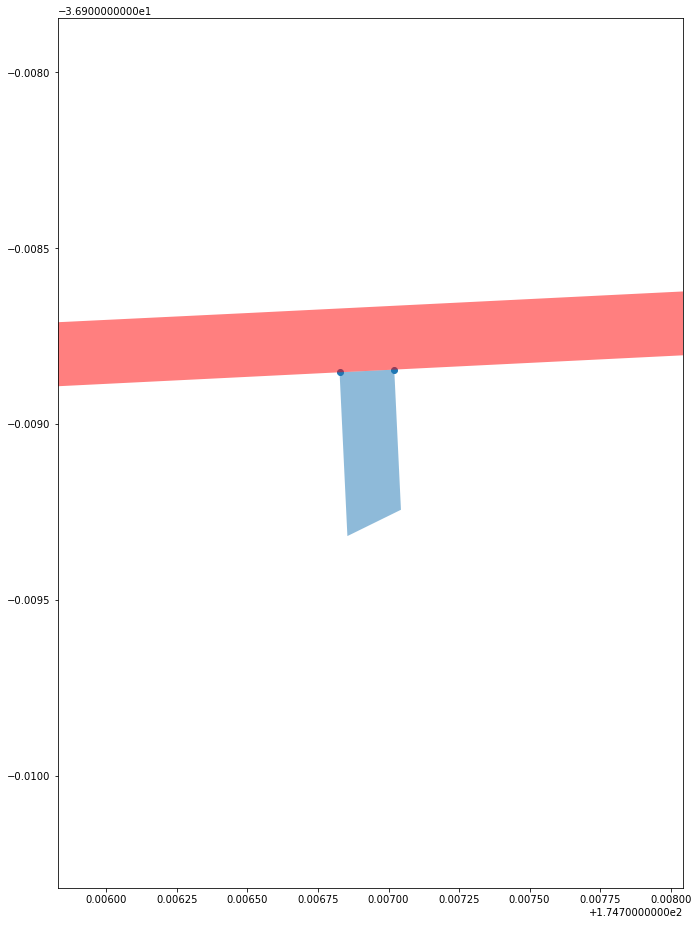

In [23]:
# example
# get a sample 
sample = parcels_output.sample(10000)
# sample one row that has a non empty list of road vertices
sample = sample[sample.apply(lambda x: len(x.LINZ_parcel_roadvertices_lat) != 0, axis=1)].sample(1)
road_points = get_points_in_roads((None, sample.iloc[0]), return_matarray=False)
ax = gpd.GeoDataFrame(geometry=road_points).plot()
sample.plot(ax=ax, alpha=0.5)
roads_dissolved.plot(ax=ax, color='red', alpha=0.5)
x1, y1, x2, y2 = sample.buffer(0.001).total_bounds
plt.xlim(x1, x2)
plt.ylim(y1, y2)
plt.draw()

In [24]:
print('1fg complete')
print(time.time() - last, 'seconds')
last = time.time()
print()

1fg complete
3126.352714538574 seconds



##### h. **LINZ_adjoining_parcel_ID** id of adjoining LINZ parcels  
##### i. **LINZ_parcel_sides_zones** AUP Zone Code of adjoining parcels (this includes residential, business, and rural zones; it should also include roads, water and open spaces)  
For convenience/speed, 1h and 1i can be gotten simultaneously.  
**Note**: not doing it for each side of a parcel. Only taking a neighbouring parcel once, even if it borders more than one side.  

Do 2a and 2b here first, which are needed for 1i.  

What to use for joining parcels with AUP zones?  
- intersect: fails because a parcel's exterior might intersect with an AUP zone's exterior, without any overlap
- overlap: fails because it is false if one polygon is contained completely within the other  
To use polygon/polygon operations, a combination would be needed; something like intersects but does not touch.  
Better to use a representative point - which *may* miss cases when a parcel is spread over two AUP zones (not sure if that occurs).  
Bonus: representative point + within is many, many, many times faster than using intersects + not touches (~10s vs not finishing before killing after at least 30 minutes)

**first, 2a and 2b** - needed for 1i.

In [ ]:
# %%time
aup_zones = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_BaseZone.shp')
aup_zones.sindex
aup_zones.sample(3)

In [ ]:
# use 2193 for AUP; this will be useful later when calculating haversine distances to nearest zones
# representative point is much faster for sjoin
parcels['geometry'] = parcels.representative_point_2193
parcels = parcels.set_crs(2193)
aup_zones = aup_zones.to_crs(parcels.crs)
aup_zones = aup_zones.rename(columns={'ZONE_resol': 'LINZmatch_AUP_name', 'ZONE': 'LINZmatch_AUP_code'})

In [ ]:
# %%time
parcels_zoned = gpd.sjoin(parcels, aup_zones[['LINZmatch_AUP_name', 'LINZmatch_AUP_code', 'geometry']], how='left', op='within').drop(columns=['index_right'])
# index for dropping duplicates
parcels_zoned['index_'] = parcels_zoned.index
parcels_zoned = parcels_zoned.drop_duplicates(subset=['index_', 'LINZmatch_AUP_code'])
# # only one parcel falls in two AUP zone polygons with different zone codes 
# display(parcels_zoned.loc[parcels_zoned.index.value_counts().index[0]][['LINZmatch_AUP_name', 'LINZmatch_AUP_code']])
# print(np.unique(parcels_zoned.index.value_counts(), return_counts=True))

In [ ]:
# drop duplicate indexes and reassign to parcels
parcels_zoned = parcels_zoned.drop_duplicates(subset=['index_'])
parcels = parcels_zoned

In [ ]:
parcels_output['LINZmatch_AUP_code'] = parcels.loc[parcels_output.index].LINZmatch_AUP_code
parcels_output['LINZmatch_AUP_name'] = parcels.loc[parcels_output.index].LINZmatch_AUP_name

**now do 1h & 1i** (now that parcels have zones)

In [ ]:
# need polygons, will check for touching neighbours
parcels.geometry = parcels['geometry_polygon_4326']
parcels = parcels.set_crs(4326)
parcels_output.geometry = parcels_output['geometry_polygon_4326']
parcels_output = parcels_output.set_crs(4326)

In [ ]:
# %%time
# number of rows to process at once
row_chunk_size=100
def find_neighbour_info(i):
    """find neighbours of parcels from i * row_chunk_size to (i+1) * row_chunk_size, then find ids and zones of those neighbouring parcels"""
    parcels_chunk = parcels_output.iloc[i*row_chunk_size:min((i+1)*row_chunk_size, len(parcels_output))]
    neighbour_gdf = gpd.sjoin(parcels_chunk, parcels, op='touches')
    neighbour_zones = []
    neighbour_ids = []
    for idx in parcels_chunk.index:
        if idx in neighbour_gdf.index:
            neighbour_ids.append(neighbour_gdf.loc[[idx]].id_right.tolist())
            neighbour_zones.append(neighbour_gdf.loc[[idx]].LINZmatch_AUP_code_right.tolist())
        else:
            neighbour_ids.append([])
            neighbour_zones.append([])
    return neighbour_ids, neighbour_zones
        
# each call to find_neighbours will return two lists like this: [list of neighbour ids], [list of niehgbour zones]
# The final structure will be of shape (n_chunks, 2, n_neighbours), where n_neighbours will vary between lists
parcel_neighbour_chunks = process_map(find_neighbour_info, list(range((int(np.ceil(len(parcels_output) / row_chunk_size))))), max_workers=max_workers, chunksize=10)

In [ ]:
parcels_output['LINZ_adjoining_parcel_ID'] = [ids for chunk in parcel_neighbour_chunks for ids in chunk[0]]
parcels_output['LINZ_parcel_sides_zones'] = [zones for chunk in parcel_neighbour_chunks for zones in chunk[1]]

In [ ]:
# plot a random parcel and its neighbours
sample = parcels_output.sample(1)
ax = sample.plot(color='red')
parcels[parcels.id.isin(sample.LINZ_adjoining_parcel_ID.values[0])].plot(ax=ax)


In [ ]:
print('2ab 1hi complete')
print(time.time() - last, 'seconds')
last = time.time()
print()

##### j. i. **LINZ_TRNSPWR_ohead_indicator** Indicator (0 or 1) for LINZ parcel located under overhead transpower line. Leave blank otherwise. Note that ‘TRANSLINE’ denotes overhead transmission lines in the GIS dataset, while ‘CABLE’ denotes underground transmission lines and can be ignored. 
##### j. ii. **LINZ_TRNSPWR_ohead_name**  
Note: What name to use? 'descriptio'? 

In [ ]:
power = gpd.read_file('input/Transmission_Lines_exTRANSPOWER.zip!Transmission_Lines.shp').to_crs(parcels_output.crs)
# only interested in overhead
power = power[power['type'] == 'TRANSLINE']
power.sample(3)

In [ ]:
# %%time
# get dataframe associating parcel indices with overhead power lines
# alternative approach is to do how='left', then combine on index using group by, but that seems much slower when incorporating the results into the final gdf
power_intersect = gpd.sjoin(parcels_output, power[['descriptio', 'geometry']]).drop(columns=['index_right'])

In [ ]:
power_intersect.index.value_counts()

In [ ]:
# %%time
def get_powerlines(id):
    if id in power_intersect.index:
        powerlines = power_intersect.loc[[id]]
        # filter out duplicates
        return powerlines.descriptio.unique().tolist()
#         return ','.join(powerlines.descriptio.unique())

    else:
        return None
parcel_powerlines = process_map(get_powerlines, list(parcels_output.index), max_workers=max_workers, chunksize=1000)
parcels_output['LINZ_TRNSPWR_ohead_name'] = parcel_powerlines
parcels_output['LINZ_TRNSPWR_ohead_indicator'] = [int(p is not None) for p in parcel_powerlines]

In [ ]:
ax = parcels_output[parcels_output['LINZ_TRNSPWR_ohead_indicator'] == 1].plot()
power.plot(column='designvolt', legend=True, ax=ax)
plt.xlim((parcels_output.total_bounds[0], parcels_output.total_bounds[2]))
plt.ylim((parcels_output.total_bounds[1], parcels_output.total_bounds[3]))
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=parcels_output.crs)

In [ ]:
print('1j complete')
print(time.time() - last, 'seconds')
last = time.time()
print()

##### k. i. **LINZ_VWSHFT_ohead_indicator** Indicator (0 or 1) for LINZ parcel located under viewshafts. Leave blank otherwise. 
##### k. ii. **LINZ_VWSHFT_ohead_name** Name of the volcanic cone (e.g. Mt Albert). Leave blank if no viewshaft applies. 
##### k. iii. **LINZ_VWSHFT_ohead_ID** OBJECTID of the viewshaft. Leave blank if no viewshaft applies.  

In [ ]:
viewshafts_local = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_LocallySignificantVolcanicViewshafts.shp').to_crs(parcels_output.crs)
viewshafts_regional = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_RegionallySignificantVolcanicViewShaftsAndHeightSensitiveAreasOverlay.shp').to_crs(parcels_output.crs)
viewshafts_museum = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_AucklandMuseumViewshaftOverlay.shp').to_crs(parcels_output.crs)

# include dilworth?
viewshafts_dilworth = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_DilworthTerraceHousesViewshaftOverlay.shp').to_crs(parcels_output.crs)

viewshafts_museum['OBJECTID'] = ['Museum_' + str(s) for s in viewshafts_museum['OBJECTID']]
viewshafts_regional['OBJECTID'] = ['RSVS_' + str(s) for s in viewshafts_regional['OBJECTID']]
viewshafts_local['OBJECTID'] = ['LSVS_' + str(s) for s in viewshafts_local['OBJECTID']]

viewshafts = pd.concat([viewshafts_museum, viewshafts_local, viewshafts_regional])

In [ ]:
# %%time
joined = gpd.sjoin(parcels_output, viewshafts[["NAME", "OBJECTID", "geometry"]])

In [ ]:
# %%time
def get_viewshafts(id):
    if id in joined.index:
        vs = joined.loc[[id]]
        # filter out duplicates
        return vs["OBJECTID"].unique().tolist(), vs["NAME"].unique().tolist()
    else:
        return None
    
parcel_viewshafts = process_map(get_viewshafts, list(parcels_output.index), max_workers=max_workers, chunksize=1000)

parcels_output['LINZ_VWSHFT_ohead_name'] = [vs[1] if vs is not None else None for vs in parcel_viewshafts]
parcels_output['LINZ_VWSHFT_ohead_ID'] = [vs[0] if vs is not None else None for vs in parcel_viewshafts]
parcels_output['LINZ_VWSHFT_ohead_indicator'] = [int(p is not None) for p in parcel_viewshafts]

In [ ]:
ax = parcels_output[parcels_output.LINZ_VWSHFT_ohead_indicator == 1].plot()
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=parcels_output.crs)

In [ ]:
print('1 all complete')
print(time.time() - last, 'seconds')
last = time.time()
print()

## 2. AUP shapefile information. Calculations are based on centroid of matched parcels: 
##### a. **LINZmatch_AUP_name** AUP zone (string) consent is located in (from the AUP shapefiles) 
##### b. **LINZmatch_AUP_code** AUP Zone Code (numerical) consent is located in   
Done above in 1h and 1i.

##### c. **Hdist_rural** Minimum Haversine distance to nearest Rural Zone,   plus
##### c. i. **Hdist_rural_name** Name of rural zone identified 
##### c. ii. **Hdist_rural_code** Numeric code of rural zone identified  
I've included all of these as rural:  
['Rural - Mixed Rural Zone',  
'Rural - Rural Coastal Zone',  
'Rural - Countryside Living Zone',  
'Rural - Rural Production Zone',  
'Rural - Rural Conservation Zone',  
'Rural - Waitakere Ranges Zone',  
'Rural - Waitakere Foothills Zone']    

In [ ]:
# dealing with distances: everything should be epsg 2193
parcels_output['geometry'] = parcels_output.geometry_polygon_2193
parcels_output = parcels_output.set_crs(2193)

In [ ]:
# %%time
aup_zones = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_BaseZone.shp')
aup_zones = aup_zones.to_crs(2193)
aup_zones.sample(3)

In [ ]:
rural_codes = aup_zones[aup_zones.ZONE_resol.str.lower().str.contains('rural - ', na=False)]['ZONE'].unique()

In [ ]:
# check that each rural zone code matches with a unique rural zone name 
assert all([len(aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()) == 1 for code in rural_codes])
# dictionary mapping code to names
rural_code2name = {code: aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()[0] for code in rural_codes}

In [ ]:
aup_zones[aup_zones.ZONE_resol.isna()]

In [ ]:
# 2 NAs in ZONE_resol are from a zone 58, which only has observations
aup_zones[aup_zones.ZONE == '58']

In [ ]:
rural = aup_zones[aup_zones.ZONE.isin(rural_codes)]

In [ ]:
rural_by_zone_dict = {code: rural[rural.ZONE == code].dissolve() for code in rural_codes}

def find_nearest(item):
    index, row = item
    distance_candidates = []
    code_candidates = []
    for code, rural_gdf in rural_by_zone_dict.items():
        distance_candidates.append(row.geometry.distance(rural_gdf.geometry[0]))
        code_candidates.append(rural_gdf.ZONE[0])
    return distance_candidates, code_candidates

# this might hang for a few minutes before multiprocessing starts
output = process_map(find_nearest, parcels_output.iterrows(), max_workers=max_workers, chunksize=100, total=len(parcels_output))

# all distances (to any zone)
distance_candidates = np.array([x[0] for x in output])
code_candidates = np.array([x[1] for x in output])

# indices of minimum distances
min_idx = np.argmin(distance_candidates, axis=-1)

In [ ]:
parcels_output['Hdist_rural'] = distance_candidates[(np.arange(len(distance_candidates)), min_idx)]
parcels_output['Hdist_rural_code'] = code_candidates[(np.arange(len(distance_candidates)), min_idx)]
parcels_output['Hdist_rural_name'] = parcels_output.apply(lambda x: rural_code2name[x.Hdist_rural_code], axis=1)

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

colours = ('blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'cyan')
name2colour = {name: colour for name, colour in zip(rural_code2name.values(), colours)}

column = 'Hdist_rural'
subsample = parcels_output[parcels_output[column] > 0].sample(10)
subsample['buffer'] = subsample.apply(lambda x: x.geometry.buffer(x[column]), axis=1)
subsample['geometry'] = subsample['buffer']
subsample = subsample[~subsample.is_empty]
# ax = rural.plot(column='ZONE_resol', legend=True)
# subsample.plot(column='Hdist_rural_name', alpha=0.4, ax=ax)
ax = rural.plot(color=[name2colour[z] for z in rural.ZONE_resol])
subsample.plot(color=[name2colour[z] for z in subsample.Hdist_rural_name], alpha=0.65, ax=ax)
# plt.ylim((5.88e6, 5.96e6))

# add legend
legend_patches = [mpatches.Patch(color=col, label=name) for name, col in name2colour.items()]
plt.legend(handles=legend_patches)

# ctx.add_basemap(ax=ax, crs=subsample.crs)

In [ ]:
print('2c complete')
print(time.time() - last, 'seconds')
last = time.time()
print()

##### d. **Hdist_bus** Minimum Haversine distance to nearest Business Zone
##### d. i. **Hdist_bus_name**
##### d. ii. **Hdist_bus_code**

In [ ]:
business_codes = aup_zones[aup_zones.ZONE_resol.str.lower().str.contains('business - ', na=False)]['ZONE'].unique()

In [ ]:
# check that each business zone code matches with a unique business zone name 
if not all([len(aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()) == 1 for code in business_codes]):
    print('warning: business zone code(s) match non uniquely with business zone names
# dictionary mapping code to names
business_code2name = {code: aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()[0] for code in business_codes}
business_code2name

In [ ]:
business = aup_zones[aup_zones.ZONE.isin(business_codes)]

In [ ]:
business_by_zone_dict = {code: business[business.ZONE == code].dissolve() for code in business_codes}

def find_nearest(item):
    index, row = item
    distance_candidates = []
    code_candidates = []
    for code, business_gdf in business_by_zone_dict.items():
        distance_candidates.append(row.geometry.distance(business_gdf.geometry[0]))
        code_candidates.append(business_gdf.ZONE[0])
    return distance_candidates, code_candidates

# this might hang for a few minutes before multiprocessing starts
output = process_map(find_nearest, parcels_output.iterrows(), max_workers=max_workers, chunksize=100, total=len(parcels_output))

# all distances (to any zone)
distance_candidates = np.array([x[0] for x in output])
code_candidates 
# indices of minimum distances
min_idx = np.argmin(distance_candidates, axis=-1)

In [ ]:
parcels_output['Hdist_bus'] = distance_candidates[(np.arange(len(distance_candidates)), min_idx)]
parcels_output['Hdist_bus_code'] = code_candidates[(np.arange(len(distance_candidates)), min_idx)]
parcels_output['Hdist_bus_name'] = parcels_output.apply(lambda x: business_code2name[x.Hdist_bus_code], axis=1)

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

colours = ('blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'cyan', 'black', 'white')
name2colour = {name: colour for name, colour in zip(business_code2name.values(), colours)}

# hard to see, subset to smaller area
bounds = {'x1': 1.76e6, 'x2': 1.7613e6, 'y1': 5.9123e6, 'y2': 5.914e6}

column = 'Hdist_bus'
subsample = parcels_output.cx[bounds['x1']:bounds['x2'], bounds['y1']:bounds['y2']]
subsample['buffer'] = subsample.apply(lambda x: x.geometry.buffer(x[column]), axis=1)
subsample['geometry'] = subsample['buffer']

subsample = subsample[~subsample.is_empty]

business_plot = business.cx[bounds['x1']:bounds['x2'], bounds['y1']:bounds['y2']]
ax = business_plot.plot(color=[name2colour[z] for z in business_plot.ZONE_resol])
subsample.plot(color=[name2colour[z] for z in subsample.Hdist_bus_name], alpha=0.65, ax=ax)
# plt.ylim((5.88e6, 5.96e6))

# add legend
legend_patches = [mpatches.Patch(color=col, label=name) for name, col in name2colour.items()]
plt.legend(handles=legend_patches)

# ctx.add_basemap(ax=ax, crs=subsample.crs)

In [ ]:
print('2d complete')
print(time.time() - last, 'seconds')
last = time.time()
print()

##### e. **Hdist_resid** Minimum Haversine distance to nearest Residential Zone,
##### e. i. **Hdist_resid_name**
##### e. ii. **Hdist_resid_code**

In [ ]:
resid_codes = aup_zones[aup_zones.ZONE_resol.str.lower().str.contains('resid', na=False)]['ZONE'].unique()

In [ ]:
resid_codes

In [ ]:
# check that each resid zone code matches with a unique resid zone name 
assert all([len(aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()) == 1 for code in resid_codes])
# dictionary mapping code to names
resid_code2name = {code: aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()[0] for code in resid_codes}
resid_code2name

In [ ]:
resid = aup_zones[aup_zones.ZONE.isin(resid_codes)]

In [ ]:
resid_by_zone_dict = {code: resid[resid.ZONE == code].dissolve() for code in resid_codes}

def find_nearest(item):
    index, row = item
    distance_candidates = []
    code_candidates = []
    for code, gdf in resid_by_zone_dict.items():
        distance_candidates.append(row.geometry.distance(gdf.geometry[0]))
        code_candidates.append(gdf.ZONE[0])
    return distance_candidates, code_candidates

# this might hang for a few minutes before multiprocessing starts
output = process_map(find_nearest, parcels_output.iterrows(), max_workers=max_workers, chunksize=100, total=len(parcels_output))

# all distances (to any zone)
distance_candidates = np.array([x[0] for x in output])
code_candidates = np.array([x[1] for x in output])

# indices of minimum distances
min_idx = np.argmin(distance_candidates, axis=-1)

In [ ]:
parcels_output['Hdist_resid'] = distance_candidates[(np.arange(len(distance_candidates)), min_idx)]
parcels_output['Hdist_resid_code'] = code_candidates[(np.arange(len(distance_candidates)), min_idx)]
parcels_output['Hdist_resid_name'] = parcels_output.apply(lambda x: resid_code2name[x.Hdist_resid_code], axis=1)

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

colours = ('blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'cyan', 'black', 'white')
name2colour = {name: colour for name, colour in zip(resid_code2name.values(), colours)}

# hard to see, subset to smaller area
bounds = {'x1': 1.76e6, 'x2': 1.7613e6, 'y1': 5.9123e6, 'y2': 5.914e6}

column = 'Hdist_resid'
subsample = parcels_output.cx[bounds['x1']:bounds['x2'], bounds['y1']:bounds['y2']]
subsample['buffer'] = subsample.apply(lambda x: x.geometry.buffer(x[column]), axis=1)
subsample['geometry'] = subsample['buffer']

subsample = subsample[~subsample.is_empty]

resid_plot = resid.cx[bounds['x1']:bounds['x2'], bounds['y1']:bounds['y2']]
ax = resid_plot.plot(color=[name2colour[z] for z in resid_plot.ZONE_resol])
subsample.plot(color=[name2colour[z] for z in subsample.Hdist_resid_name], alpha=0.65, ax=ax)
# plt.ylim((5.88e6, 5.96e6))

# add legend
legend_patches = [mpatches.Patch(color=col, label=name) for name, col in name2colour.items()]
plt.legend(handles=legend_patches)

# ctx.add_basemap(ax=ax, crs=subsample.crs)

In [ ]:
print('2e complete')
print(time.time() - last, 'seconds')
last = time.time()
print()

##### f. **Hdist_SH** Minimum Haversine distance to Residential - Single House Zone 
##### g. **Hdist_MHS** Minimum Haversine distance to Residential - Mixed Housing Suburban Zone
##### h. **Hdist_MHU** Minimum Haversine distance to Residential - Mixed Housing Urban Zone  
##### i. **Zone Hdist_THA** Minimum Haversine distance to Residential - Terrace Housing and Apartments
Note: this is the real name for i: 'Residential - Terrace Housing and Apartment Building Zone'

In [ ]:
# %%time
postfix2name = {
            'SH': 'Residential - Single House Zone',
            'MHS': 'Residential - Mixed Housing Suburban Zone',
            'MHU': 'Residential - Mixed Housing Urban Zone',
            'THA': 'Residential - Terrace Housing and Apartment Building Zone'
               }
for postfix, zone in tqdm(postfix2name.items()):
    resid_gdf = resid[resid.ZONE_resol == zone].dissolve()
    def get_distance(geo):
        return geo.distance(resid_gdf.geometry[0])
    parcels_output[f'Hdist_{postfix}'] = process_map(get_distance, parcels_output.geometry, max_workers=max_workers, chunksize=100)

In [ ]:
postfix = 'THA'
column = f'Hdist_{postfix}'
subsample = parcels_output.sample(10)
subsample['buffer'] = subsample.apply(lambda x: x.geometry.buffer(x[column]), axis=1)
subsample['geometry'] = subsample['buffer']
ax = subsample.plot(color='red', alpha=0.4)
resid[resid.ZONE_resol == postfix2name[postfix]].plot(ax=ax)
ctx.add_basemap(ax, crs=2193)

In [ ]:
print('2fghi complete')
print(time.time() - last, 'seconds')
last = time.time()
print()

In [ ]:
print('2 all complete')

## 3-7: Areas that parcels are located in (e.g. sa2, aup etc.)  
3 - 7 will be done all at once, in a for loop below; but first, load in data and set up parameters.  
Parcels often end up overlapping multiple areas; in this case, use the area with the greatest overlap.

In [ ]:
parcels_output['geometry'] = parcels_output['geometry_polygon_2193']
parcels_output = parcels_output.set_crs(2193)
# gdf will have columns added to it (in the for loop below). Eventually it will be assigned to parcels_output.
gdf = parcels_output
# set of params to iterate over
param_sets = []

### 3. Local Area (LA) Information (information on the LA that the consent is located in): 

##### a. Name (just the string is fine; I did not generate numeric codes for the local areas generated) **Local_Area_name**

In [ ]:
LA = gpd.read_file('input/Modified_Community_Boards_SHP.zip').to_crs(parcels_output.crs)
LA = LA.rename(columns={'Local_Area': 'Local_Area_name'})
LA.sindex

param_sets.append(
    {
        'area_gdf': LA,
        'area_code_col': 'Local_Area_name',
    }
)

LA.sample(3)

### 4. 2018 Statistical Area 2 Information (information on the 2018SA2 that the consent is located in)

##### a. Name (string) **SA22018_name**
##### b. Numeric code **SA22018_code**

In [ ]:
sa2 = gpd.read_file('input/statsnzstatistical-area-2-higher-geographies-2018-clipped-generalis-FGDB.zip!statistical-area-2-higher-geographies-2018-clipped-generalis.gdb').to_crs(parcels_output.crs)
sa2 = sa2.cx[parcels_output.total_bounds[0]:parcels_output.total_bounds[2], parcels_output.total_bounds[1]:parcels_output.total_bounds[3]]
sa2 = sa2.rename(columns={'SA22018_V1_00': 'SA22018_code', 'SA22018_V1_00_NAME': 'SA22018_name'})
sa2.sindex

param_sets.append(
    {
        'area_gdf': sa2,
        'area_code_col': 'SA22018_code',
        'area_name_col': 'SA22018_name'
    }
)

sa2.sample(3)

### 5. Area Unit Information (information on the 2013AU  that the consent is located in):

##### a. Name (string) **AU2013_name**
##### b. Numeric code **AU2013_code**

In [ ]:
au2013 = gpd.read_file('input/area-unit-2013.gdb.zip').to_crs(parcels_output.crs)
au2013 = au2013.cx[parcels_output.total_bounds[0]:parcels_output.total_bounds[2], parcels_output.total_bounds[1]:parcels_output.total_bounds[3]]
au2013 = au2013.rename(columns={'AU2013_V1_00': 'AU2013_code', 'AU2013_V1_00_NAME': 'AU2013_name'})
au2013.sindex

param_sets.append(
    {
        'area_gdf': au2013,
        'area_code_col': 'AU2013_code',
        'area_name_col': 'AU2013_name'
    }
)

au2013.sample(3)

### 6. 2018 Meshblock Information (information on the 2018MB  that the consent is located in):

##### a. Code **MB2018_code**

In [ ]:
mb2018 = gpd.read_file('input/meshblock-2018-clipped-generalised.gdb.zip').to_crs(parcels_output.crs)
mb2018 = mb2018.cx[parcels_output.total_bounds[0]:parcels_output.total_bounds[2], parcels_output.total_bounds[1]:parcels_output.total_bounds[3]]
mb2018 = mb2018.rename(columns={'MB2018_V1_00': 'MB2018_code'})
mb2018.sindex

param_sets.append(
    {
        'area_gdf': mb2018,
        'area_code_col': 'MB2018_code'
    }
)

mb2018.sample(3)

### 7. 2013 Meshblock Information (information on the 2013MB  that the consent is located in):

##### a. Code **MB2013_code**

In [ ]:
mb2013 = gpd.read_file('input/meshblock-2013.gdb.zip').to_crs(parcels_output.crs)
mb2013 = mb2013.cx[parcels_output.total_bounds[0]:parcels_output.total_bounds[2], parcels_output.total_bounds[1]:parcels_output.total_bounds[3]]
mb2013 = mb2013.rename(columns={'MeshblockNumber': 'MB2013_code'})
mb2013.sindex

param_sets.append(
    {
        'area_gdf': mb2013,
        'area_code_col': 'MB2013_code'
    } 
)

mb2013.sample(3)

In [ ]:
print('3-7 reading files complete')
print(time.time() - last, 'seconds')
last = time.time()
print()

## 3 - 7. perform the joins

In [ ]:
for params in param_sets:
    area_gdf = params['area_gdf']
    area_code_col = params['area_code_col']
    area_name_col = params.get('area_name_col')
    
    print('adding', area_code_col)
    
    # join
    keep_cols = ([area_name_col] if area_name_col else []) + [area_code_col]
    joined = gpd.sjoin(gdf.drop(keep_cols, errors='ignore', axis=1), area_gdf[keep_cols + ['geometry']], how='left').drop(columns=['index_right'])

    # find how many times each index value appears
    # more than one appearence indicates more than one area has been matched
    n_matched = joined.index.value_counts()
    # get indices with more than one match
    ambiguous_idx = n_matched[n_matched > 1].index

    print(len(ambiguous_idx), 'parcels matched to multiple areas')

    def find_greatest_area_match(idx):
        """find the overlapping area with the greatest area"""
        # get the corresponding parcel
        parcel = gdf.loc[[idx]][['geometry']]
        # get the matching areas
        matching = area_gdf[area_gdf[area_code_col].isin(joined.loc[idx][area_code_col])]
        # break into distinct regions
        overlaid = gpd.overlay(parcel, matching)
        if area_name_col:
            return overlaid.loc[np.argmax(overlaid.area)][area_code_col], overlaid.loc[np.argmax(overlaid.area)][area_name_col]
        return overlaid.loc[np.argmax(overlaid.area)][area_code_col]

    area_matches = process_map(find_greatest_area_match, ambiguous_idx, max_workers=max_workers, chunksize=10)

    # keep first row of groups of duplicates indexes
    joined = joined[~joined.index.duplicated(keep='first')]
    # replace area code with that with largest overlap
    
    if area_name_col:
        joined.loc[ambiguous_idx, area_code_col] = [a[0] for a in area_matches]
        joined.loc[ambiguous_idx, area_name_col] = [a[1] for a in area_matches]
    else:
        joined.loc[ambiguous_idx, area_code_col] = area_matches
    
    gdf = joined
    
    print()
    # store ambiguous idx for later, e.g. plotting
    params['ambiguous_idx'] = ambiguous_idx

In [ ]:
original_parcels_output = parcels_output.copy()
parcels_output = gdf

In [ ]:
# red outline: parcel
# hatched: largest overlapping area
# others: other areas that intersect the parcel
params = param_sets[np.random.randint(len(param_sets))]
ambiguous_idx = params['ambiguous_idx']
area_gdf = params['area_gdf']
area_code_col = params['area_code_col']

plot_idx = ambiguous_idx[np.random.randint(len(ambiguous_idx))]
plot_gdf = gdf.loc[[plot_idx]]
plot_mb = gpd.sjoin(params['area_gdf'][[params['area_code_col'], 'geometry']], plot_gdf[['geometry']]).drop(columns=['index_right'])

plot_bounds = plot_gdf.buffer(100).total_bounds

ax = area_gdf[area_gdf[area_code_col] == gdf.loc[plot_idx][area_code_col]].plot(facecolor='None',hatch= "///")
plot_gdf.boundary.plot(color='red', ax=ax)

plot_mb.boundary.plot(ax=ax, alpha=0.3)
plot_mb.plot(ax=ax, column=area_code_col, legend=True, alpha=0.3)

plt.xlim((plot_bounds[0], plot_bounds[2]))
plt.ylim((plot_bounds[1], plot_bounds[3]))
plt.title(area_code_col)
# ctx.add_basemap(ax, crs=plot_gdf.crs, source=ctx.providers.Esri.WorldImagery)
plt.draw()

In [ ]:
print('3-7 complete')
print(time.time() - last, 'seconds')
last = time.time()
print()

## 8. Additional distance information from consent location  
For these distance calculations, use EPSG 2193 (less distortion).

In [ ]:
parcels_output['geometry'] = parcels_output['geometry_centroid_2193']
parcels_output = parcels_output.set_crs(2193)

#### a. Minimum Haversine distance to coastline **Hdist_coast**  
There are a few different datasets that could be used for this:  
    - NZ Coastlines (Topo 1:50k) https://data.linz.govt.nz/layer/50258-nz-coastlines-topo-150k/
    - NZ Coastline - mean high water https://data.linz.govt.nz/layer/105085-nz-coastline-mean-high-water/
    - NZ Coastlines and Islands Polygons (Topo 1:50k) https://data.linz.govt.nz/layer/51153-nz-coastlines-and-islands-polygons-topo-150k/  

The first doesn't have islands (e.g. Waiheke).  
The second is probably most appropriate.

In [ ]:
# %%time
coastline = gpd.read_file('input/lds-nz-coastline-mean-high-water-FGDB.zip!nz-coastline-mean-high-water.gdb').to_crs(2193)
coastline = coastline.cx[parcels_output.total_bounds[0]:parcels_output.total_bounds[2], parcels_output.total_bounds[1]:parcels_output.total_bounds[3]]

coastline_dissolved = coastline.dissolve()

In [ ]:
# %%time
def extract_coastal_dist(geom):
    return geom.distance(coastline_dissolved.geometry[0])

parcels_output['Hdist_coast'] = process_map(extract_coastal_dist, parcels_output.geometry, max_workers=max_workers, chunksize=10)

In [ ]:
# if distance work, then red circles should extend to the nearest coastline, and no further
subsample = parcels_output.sample(10)
subsample['coast_buffer'] = subsample.apply(lambda x: x.geometry.buffer(x.Hdist_coast), axis=1)
subsample['geometry'] = subsample['coast_buffer']
ax = subsample.plot(color='red', alpha=0.4)
coastline.cx[1.7e6:1.8e6, 5.85e6:5.97e6].plot(ax=ax)

In [ ]:
print('8a complete')
print(time.time() - last, 'seconds')
last = time.time()
print()

##### b. Minimum Haversinedistance to Open Space(set of AUP Zones) **Hdist_open**

##### c. Minimum Haversine distance to motorway **Hdist_motorway**
##### d. Minimum Haversine distance to main arterial road **Hdist_main_road**

In [ ]:
parcels_output['geometry'] = parcels_output['geometry_centroid_2193']
parcels_output = parcels_output.set_crs(2193)

In [ ]:
roads = gpd.read_file('input/lds-nz-road-centrelines-topo-150k-FGDB.zip!nz-road-centrelines-topo-150k.gdb').to_crs(2193)
roads = roads.cx[parcels_output.total_bounds[0]:parcels_output.total_bounds[2], parcels_output.total_bounds[1]:parcels_output.total_bounds[3]]
highways = roads[~roads.hway_num.isna()]
highways_dissolved = highways.dissolve()
arterial_roads = gpd.read_file('input/2016_aup.zip!2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_ArterialRoad.shp').to_crs(2193)
arterial_roads_dissolved = arterial_roads.dissolve()

In [ ]:
ax = highways.plot()
arterial_roads.plot(ax=ax, color='red')
ctx.add_basemap(ax, crs=arterial_roads.crs)

In [ ]:
def extract_highway_dist(geom):
    return geom.distance(highways_dissolved.geometry[0])

def extract_main_road_dist(geom):
    return geom.distance(arterial_roads_dissolved.geometry[0])

# parcels_output['Hdist_motorway'] = parcels_output.progress_apply(lambda x: x.geometry.distance(highways_dissolved.geometry[0]), axis=1)
parcels_output['Hdist_motorway'] = process_map(extract_highway_dist, parcels_output.geometry, max_workers=max_workers, chunksize=10)
# parcels_output['Hdist_main_road'] = parcels_output.progress_apply(lambda x: x.geometry.distance(arterial_roads_dissolved.geometry[0]), axis=1)
parcels_output['Hdist_main_road'] = process_map(extract_main_road_dist, parcels_output.geometry, max_workers=max_workers, chunksize=10)

In [ ]:
# if distance work, then red circles should extend to the nearest coastline, and no further
subsample = parcels_output.sample(10)
subsample['highway_buffer'] = subsample.apply(lambda x: x.geometry.buffer(x.Hdist_motorway), axis=1)
subsample['geometry'] = subsample['highway_buffer']
ax = subsample.plot(color='red', alpha=0.4)
highways.plot(ax=ax)

In [ ]:
print('8bcd complete')
print(time.time() - last, 'seconds')
last = time.time()
print()

##### e. Minimum Haversine distance to rail line **Hdist_rail**

In [ ]:
railroads = gpd.read_file('input/lds-nz-railway-centrelines-topo-150k-SHP.zip').to_crs(2193)
railroads = railroads.cx[parcels_output.total_bounds[0]:parcels_output.total_bounds[2], parcels_output.total_bounds[1]:parcels_output.total_bounds[3]]
railroads_dissolved = railroads.dissolve()

In [ ]:
parcels_output['geometry'] = parcels_output['geometry_centroid_2193']
parcels_output = parcels_output.set_crs(2193)
def get_rail_distance(geom):
    return geom.distance(railroads_dissolved.geometry[0])

parcels_output['Hdist_rail'] = process_map(get_rail_distance, parcels_output.geometry, max_workers=max_workers, chunksize=10)

In [ ]:
subsample = parcels_output.sample(10)
subsample['rail_buffer'] = subsample.apply(lambda x: x.geometry.buffer(x.Hdist_rail), axis=1)
subsample['geometry'] = subsample['rail_buffer']
ax = subsample.plot(color='red', alpha=0.4)
railroads_dissolved.plot(ax=ax)
ctx.add_basemap(ax, crs=subsample.crs)

In [ ]:
print('8e complete')
print(time.time() - last, 'seconds')
last = time.time()
print()

##### f. Haversine distance to downtown (use Skytower coordinates) **Hdist_skytower**

In [ ]:
skytower = [-36.84838748948485, 174.7621736911587]
skytower = gpd.points_from_xy(x=[skytower[1]], y=[skytower[0]])
skytower = gpd.GeoDataFrame([{"name": "Skytower", "value": 1}], geometry=skytower, crs="EPSG:4326").to_crs(epsg=2193)

In [ ]:
parcels_output['geometry'] = parcels_output['geometry_centroid_2193']
parcels_output = parcels_output.set_crs(2193)

def get_skytower_distance(geom):
    return geom.distance(skytower.geometry[0])

parcels_output['Hdist_skytower'] = process_map(get_skytower_distance, parcels_output.geometry, max_workers=max_workers, chunksize=10)

In [ ]:
# if distance works, then red circles should extend to the nearest sky tower, and no further
subsample = parcels_output.sample(10)
subsample['skytower_buffer'] = subsample.apply(lambda x: x.geometry.buffer(x.Hdist_skytower), axis=1)
subsample['geometry'] = subsample['skytower_buffer']
ax = subsample.plot(color='red', alpha=0.2)
skytower.plot(ax=ax, color='black')
ctx.add_basemap(ax, crs=parcels_output.crs)

In [ ]:
print('8f complete')
print(time.time() - last, 'seconds')
last = time.time()
print()

## 9. Special Housing Area (SpHAs)
Indicator (1 or 0) for consent located in SpHAs **SpHA_indicator**  
Note: here I've used centroids. Maybe should use parcel polygons instead.

In [ ]:
spha = gpd.read_file('input/AC_Special_Housing_Area.zip').to_crs(2193)
spha_dissolved = spha.dissolve()
assert(len(spha_dissolved) == 1)

In [ ]:
# %%time
parcels_output['geometry'] = parcels_output['geometry_centroid_2193']
parcels_output = parcels_output.set_crs(2193)

def get_spha_indicator(geom):
    return spha_dissolved.geometry.contains(geom)[0]

parcels_output['SpHA_indicator'] = process_map(get_spha_indicator, parcels_output.geometry, max_workers=max_workers, chunksize=10)

In [ ]:
subsample = parcels_output.sample(min(500, len(parcels_output)))
ax=subsample.plot(column='SpHA_indicator')
plt.ylim((5.89e6, 5.95e6))
plt.xlim((1.73e6, 1.78e6))
spha_dissolved.boundary.plot(ax=ax)
ctx.add_basemap(ax, crs=spha_dissolved.crs)

In [ ]:
print('9 complete')
print(time.time() - last, 'seconds')
last = time.time()
print()

## Save

In [ ]:
orginal_columns

In [ ]:
parcels_output['geometry'] = parcels_output.geometry_polygon_4326
parcels_output = parcels_output.set_crs(4326)

In [ ]:
parcels_output.drop(orginal_columns, axis=1, errors='ignore').to_csv('output/parcels_phase0.csv')
# errors out because some entries are lists:
# parcels_output.drop([c for c in orginal_columns if c != 'geometry'], axis=1, errors='ignore').to_file('parcels_phase0.gpkg', driver='GPKG')

In [ ]:
from datetime import timedelta
end = time.time()
elapsed = end - start
print('total execution time:', elapsed)
str(timedelta(seconds=elapsed))

In [ ]:
print('saving complete')

## 10. Ranged Address Indicator

## 11. Matching Type Indicators
##### a. LINZ_MATCH_CODE
##### b. LINZ_2ND_MATCH_CODE